# Model Training Strategy

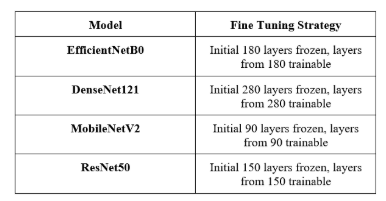


1. Input Design:

    Fingerprint images: RGB, 256×256×3.

    Tabular vector: 3-dimensional pattern distribution (Arch, Whorl, Loop).

    Hybrid input: Features from images fused with pattern distribution vector after Global Average Pooling.

2. Feature Processing:

    Image features → Global Average Pooling → concatenated with tabular features.

    Fused vector → two dense layers with dropout and L2 regularization for better generalization.

3. Optimizer & Loss:

    Optimizer: Adam with initial learning rate 1e-4.

    Loss function: Categorical cross-entropy with label smoothing (0.05).

4. Class Imbalance Handling:

    Calculated class weights to balance minority classes.

5. Data Augmentation:

    Random rotations ±7° (using Albumentations library).

    Aim: Improve generalization and reduce overfitting.

6. Training Monitoring & Learning Rate Adjustment:

    Early stopping to prevent overfitting.

    ReduceLROnPlateau to adjust learning rate during stagnation or slow convergence.

7. Ensemble Learning:

    Models ensembled: EfficientNet, MobileNet, DenseNet.

    Soft-voting with weighted averages [0.33, 0.33, 0.34].

    Improved performance for low-support classes (A−, AB−).

    Overall ensemble accuracy: 89%.

8. Performance Evaluation:

    Confusion matrix and classification report analyzed.

    Macro-average metrics used to verify balanced performance across all classes.

In [ ]:
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras.utils import Sequence, to_categorical
import albumentations as A
from typing import List, Tuple

class HybridDataGenerator(Sequence):
    """
    Hybrid data generator that combines image and tabular data with efficient augmentation.

    Args:
        df (pd.DataFrame): DataFrame containing filepaths, tabular features, and labels
        classes (List[str]): List of class names
        batch_size (int): Number of samples per batch
        img_size (Tuple[int, int]): Target image dimensions (height, width)
        shuffle (bool): Whether to shuffle data after each epoch
        augment (bool): Whether to apply data augmentation
        use_albumentations (bool): Whether to use Albumentations for augmentation (recommended)
    """

    def __init__(self,
                 df: pd.DataFrame,
                 classes: List[str],
                 batch_size: int = 32,
                 img_size: Tuple[int, int] = (256, 256),
                 shuffle: bool = True,
                 augment: bool = False,
                 use_albumentations: bool = True):

        self.df = df.reset_index(drop=True)
        self.classes = classes
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.augment = augment
        self.use_albumentations = use_albumentations
        self.class_indices = {cls: i for i, cls in enumerate(classes)}

        # Initialize augmentation pipelines
        self._init_augmentation()

        # Precompute tabular feature names
        self.tabular_features = ['Arch', 'Loop', 'Whorl']  # Adjust based on your DataFrame
        self.on_epoch_end()

    def _init_augmentation(self) -> None:
        """Initialize augmentation pipelines."""
        if self.augment:
            if self.use_albumentations:
                # Albumentations pipeline (faster and more options)
                self.albumentations_aug = A.Compose([
                    A.HorizontalFlip(p=0),
                    A.Rotate(limit=7, p=0.5)
                ])

        # Always include rescaling
        self.rescale = tf.keras.layers.Rescaling(1./255)

    def __len__(self) -> int:
        """Number of batches per epoch."""
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, index: int) -> Tuple[Tuple[np.ndarray, np.ndarray], np.ndarray]:
        """Generate one batch of data."""
        batch_df = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size]

        X_img, X_tabular, y = [], [], []

        for _, row in batch_df.iterrows():
            # Load and process image
            img = self._load_and_process_image(row['filepath'])

            # Get tabular features
            tabular_data = [row[feat] for feat in self.tabular_features]

            # Get label
            label_idx = self.class_indices[row['blood_group']]

            X_img.append(img)
            X_tabular.append(tabular_data)
            y.append(label_idx)

        # Convert to numpy arrays
        X_img = np.array(X_img)
        X_tabular = np.array(X_tabular, dtype=np.float32)
        y = to_categorical(y, num_classes=len(self.classes))

        # Apply augmentation if enabled
        if self.augment:
            X_img = self._apply_augmentation(X_img)

        # Apply rescaling
        X_img = self.rescale(X_img)

        return [X_img, X_tabular], y

    def _load_and_process_image(self, filepath: str) -> np.ndarray:
        """Load and preprocess a single image."""
        img = cv2.imread(filepath)
        if img is None:
            raise ValueError(f"Could not load image at {filepath}")

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        img = cv2.resize(img, (self.img_size[1], self.img_size[0]))  # OpenCV uses (width, height)
        return img

    def _apply_augmentation(self, images: np.ndarray) -> np.ndarray:
        """Apply augmentation to a batch of images."""
        if self.use_albumentations:
            # Albumentations augmentation
            augmented_images = []
            for img in images:
                augmented = self.albumentations_aug(image=img)['image']
                augmented_images.append(augmented)
            return np.array(augmented_images)
        else:
            # TensorFlow augmentation
            return self.tf_augmenter(tf.convert_to_tensor(images)).numpy()

    def on_epoch_end(self) -> None:
        """Shuffle data after each epoch."""
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def get_sample(self) -> Tuple[Tuple[np.ndarray, np.ndarray], np.ndarray]:
        """Get a single sample for inspection."""
        return self.__getitem__(0)

# ResNet

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (Input, Dense, Dropout, GlobalAveragePooling2D,
                                   Concatenate, BatchNormalization)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

def build_resnet(num_classes=8, img_size=(256, 256)):
    img_input = Input(shape=(256, 256, 3), name='img_input')
    pattern_input = Input(shape=(3,), name='pattern_input')  # One-hot: Arch, Whorl, Loop

    # EfficientNetB0 base
    base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=img_input)

    # Freeze initial layers (optional tuning strategy)
    for layer in base_model.layers[:150]:
        layer.trainable = False
    for layer in base_model.layers[150:]:
        layer.trainable = True

    # Image feature extraction
    x = GlobalAveragePooling2D()(base_model.output)

    # Combine image features with fingerprint pattern
    x = Concatenate()([x, pattern_input])
    x = Dense(512, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.4)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.3)(x)
    output = Dense(8, activation='softmax')(x)

    model = Model(inputs=[img_input, pattern_input], outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
        metrics=['accuracy']
    )
    return model



In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
model = build_resnet()

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True,verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=4, min_lr=1e-8,verbose=1),
    ModelCheckpoint("resnet_model_pattern.h5", monitor='val_accuracy', save_best_only=True,verbose=1)
]

history_resnet=model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=150,
    callbacks=callbacks,class_weight=class_weights_dict
)

Epoch 1/150
97/97 [==============================] - ETA: 0s - loss: 1.2625 - accuracy: 0.5986   
Epoch 1: val_accuracy improved from -inf to 0.35455, saving model to resnet_model_pattern.h5
97/97 [==============================] - 70s 440ms/step - loss: 1.2625 - accuracy: 0.5986 - val_loss: 1.8004 - val_accuracy: 0.3546 - lr: 1.0000e-04
Epoch 2/150
97/97 [==============================] - ETA: 0s - loss: 0.9003 - accuracy: 0.7742  
Epoch 2: val_accuracy improved from 0.35455 to 0.76885, saving model to resnet_model_pattern.h5
97/97 [==============================] - 39s 398ms/step - loss: 0.9003 - accuracy: 0.7742 - val_loss: 0.9513 - val_accuracy: 0.7689 - lr: 1.0000e-04
Epoch 3/150
97/97 [==============================] - ETA: 0s - loss: 0.8033 - accuracy: 0.8218  
Epoch 3: val_accuracy improved from 0.76885 to 0.80705, saving model to resnet_model_pattern.h5
97/97 [==============================] - 39s 400ms/step - loss: 0.8033 - accuracy: 0.8218 - val_loss: 0.8439 - val_accuracy: 

1/1 [==============================] - 4s 4s/step
Confusion Matrix:
 [[125   0   5   0   0   1  13   4]
 [  0 124   6   5   3   3   7   2]
 [  1   4 135   0   5   0   1   4]
 [  0  22   0 112   7   5   0   3]
 [  0   5   6   5 132   1   0   1]
 [  0   9   0   3   3 135   0   0]
 [  6   4   6   2   0   0 130   2]
 [  2   5   8   8   0   0  13 114]]
Classification Report:
               precision    recall  f1-score   support

          A+       0.93      0.84      0.89       148
          A-       0.72      0.83      0.77       150
         AB+       0.81      0.90      0.85       150
         AB-       0.83      0.75      0.79       149
          B+       0.88      0.88      0.88       150
          B-       0.93      0.90      0.92       150
          O+       0.79      0.87      0.83       150
          O-       0.88      0.76      0.81       150

    accuracy                           0.84      1197
   macro avg       0.85      0.84      0.84      1197
weighted avg       0.85      0

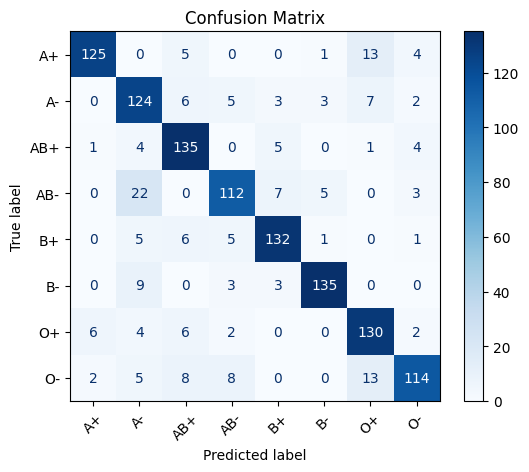

array([[125,   0,   5,   0,   0,   1,  13,   4],
       [  0, 124,   6,   5,   3,   3,   7,   2],
       [  1,   4, 135,   0,   5,   0,   1,   4],
       [  0,  22,   0, 112,   7,   5,   0,   3],
       [  0,   5,   6,   5, 132,   1,   0,   1],
       [  0,   9,   0,   3,   3, 135,   0,   0],
       [  6,   4,   6,   2,   0,   0, 130,   2],
       [  2,   5,   8,   8,   0,   0,  13, 114]], dtype=int64)

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def evaluate_model(model_path, df_test, classes):
    model = load_model(model_path)
    test_gen = HybridDataGenerator(df_test, classes, shuffle=False)
    y_true = []
    y_pred = []
    for (X_img, X_pat), y in test_gen:
        preds = model.predict([X_img, X_pat])
        y_true.extend(np.argmax(y, axis=1))
        y_pred.extend(np.argmax(preds, axis=1))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)

    # Classification Report
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=classes))

    # Visualization using ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

    return cm

classes=['A+', 'A-', 'AB+', 'AB-', 'B+', 'B-', 'O+', 'O-']  # Example call
evaluate_model(r"C:\Users\mdtan\SCOPUS Project\resnet_model_pattern.h5", df_test, classes)


# Mobile_Net

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

NUM_CLASSES = len(classes)  # ['A+', 'A-', 'AB+', 'AB-', 'B+', 'B-', 'O+', 'O-']

def build_mobilenet_hybrid():
    # Inputs
    img_input = Input(shape=(256, 256, 3), name='img_input')
    pattern_input = Input(shape=(3,), name='pattern_input')  # One-hot: Arch, Whorl, Loop

    # MobileNetV2 base model
    base_model = MobileNetV2(include_top=False, weights='imagenet', input_tensor=img_input)

    # Freeze early layers (fine-tune last few)
    for layer in base_model.layers[:90]:
        layer.trainable = False
    for layer in base_model.layers[90:]:
        layer.trainable = True

    # Image features
    x = GlobalAveragePooling2D()(base_model.output)

    # Combine with pattern features
    x = Concatenate()([x, pattern_input])
    x = Dense(512, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.4)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.3)(x)
    output = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs=[img_input, pattern_input], outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
        metrics=['accuracy']
    )
    return model


In [ ]:
mobilenet_model = build_mobilenet_hybrid()
mobilenet_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img_input (InputLayer)         [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 32  864         ['img_input[0][0]']              
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-8, verbose=1),
    ModelCheckpoint("mobilenet_model_pattern.h5", monitor='val_accuracy', save_best_only=True, verbose=1)
]

mobilenet_model = build_mobilenet_hybrid()

history_mobilenet = mobilenet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=150,
    callbacks=callbacks,
    class_weight=class_weights_dict
)


Epoch 1/150
194/194 [==============================] - ETA: 0s - loss: 1.4443 - accuracy: 0.5180   
Epoch 1: val_accuracy improved from -inf to 0.27718, saving model to mobilenet_model_pattern.h5
194/194 [==============================] - 43s 159ms/step - loss: 1.4443 - accuracy: 0.5180 - val_loss: 2.1665 - val_accuracy: 0.2772 - lr: 1.0000e-04
Epoch 2/150
194/194 [==============================] - ETA: 0s - loss: 0.9310 - accuracy: 0.7526  
Epoch 2: val_accuracy did not improve from 0.27718
194/194 [==============================] - 25s 129ms/step - loss: 0.9310 - accuracy: 0.7526 - val_loss: 2.7605 - val_accuracy: 0.2537 - lr: 1.0000e-04
Epoch 3/150
194/194 [==============================] - ETA: 0s - loss: 0.8284 - accuracy: 0.8003 
Epoch 3: val_accuracy improved from 0.27718 to 0.38688, saving model to mobilenet_model_pattern.h5
194/194 [==============================] - 27s 140ms/step - loss: 0.8284 - accuracy: 0.8003 - val_loss: 2.1204 - val_accuracy: 0.3869 - lr: 1.0000e-04
Epoc

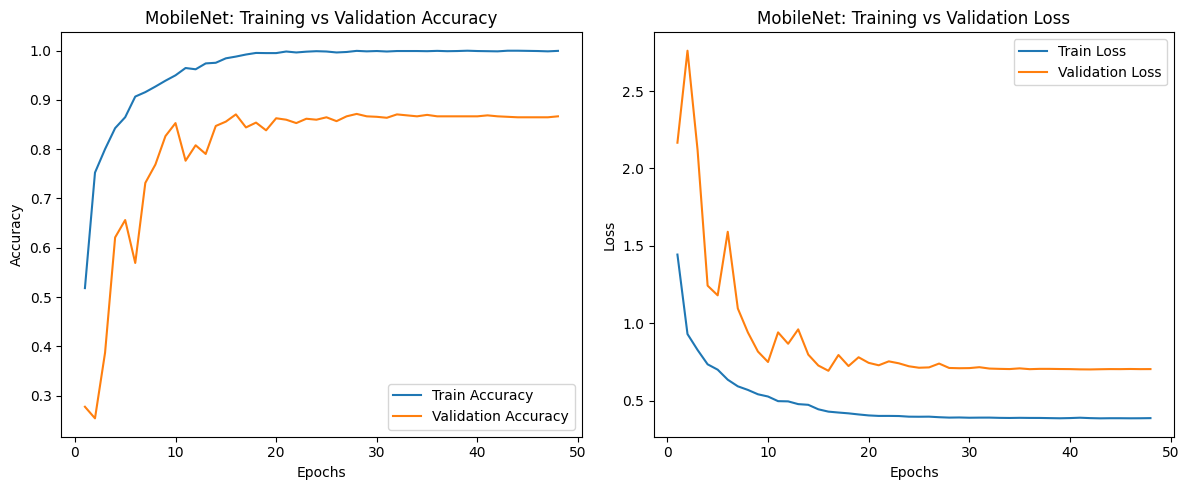

In [ ]:
import matplotlib.pyplot as plt

# Access the history dictionary from the History object
history_dict = history_mobilenet.history

epochs = range(1, len(history_dict["loss"]) + 1)
train_loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
train_acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label="Train Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("MobileNet: Training vs Validation Accuracy")

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label="Train Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("MobileNet: Training vs Validation Loss")

plt.tight_layout()
plt.show()

1/1 [==============================] - 3s 3s/step
Confusion Matrix:
 [[123   0   4   1   0   0   9  11]
 [  0 134   4   4   4   1   1   2]
 [  0   3 135   0   4   0   2   6]
 [  2  19   0 106  10   4   2   6]
 [  0   8   3   3 135   1   0   0]
 [  0   4   0   1   4 141   0   0]
 [  3   7  10   1   0   0 125   4]
 [  4   4   5   3   0   0  10 124]]
Classification Report:
               precision    recall  f1-score   support

          A+       0.93      0.83      0.88       148
          A-       0.75      0.89      0.81       150
         AB+       0.84      0.90      0.87       150
         AB-       0.89      0.71      0.79       149
          B+       0.86      0.90      0.88       150
          B-       0.96      0.94      0.95       150
          O+       0.84      0.83      0.84       150
          O-       0.81      0.83      0.82       150

    accuracy                           0.85      1197
   macro avg       0.86      0.85      0.85      1197
weighted avg       0.86      0

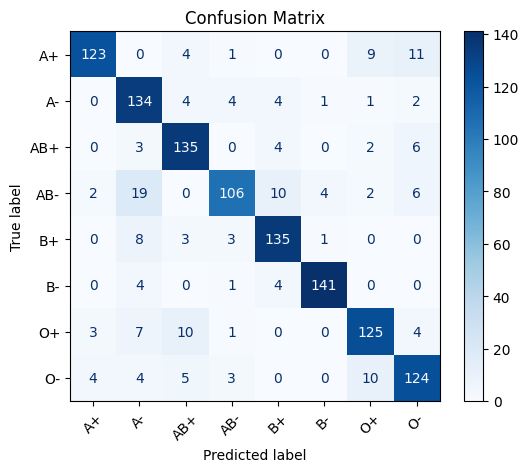

array([[123,   0,   4,   1,   0,   0,   9,  11],
       [  0, 134,   4,   4,   4,   1,   1,   2],
       [  0,   3, 135,   0,   4,   0,   2,   6],
       [  2,  19,   0, 106,  10,   4,   2,   6],
       [  0,   8,   3,   3, 135,   1,   0,   0],
       [  0,   4,   0,   1,   4, 141,   0,   0],
       [  3,   7,  10,   1,   0,   0, 125,   4],
       [  4,   4,   5,   3,   0,   0,  10, 124]], dtype=int64)

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def evaluate_model(model_path, df_test, classes):
    model = load_model(model_path)
    test_gen = HybridDataGenerator(df_test, classes, shuffle=False)
    y_true = []
    y_pred = []
    for (X_img, X_pat), y in test_gen:
        preds = model.predict([X_img, X_pat])
        y_true.extend(np.argmax(y, axis=1))
        y_pred.extend(np.argmax(preds, axis=1))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)

    # Classification Report
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=classes))

    # Visualization using ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

    return cm

classes=['A+', 'A-', 'AB+', 'AB-', 'B+', 'B-', 'O+', 'O-']  # Example call
df_test = pd.read_csv(r"C:\Users\mdtan\SCOPUS Project\imagewise_pattern_distribution_test.csv")
evaluate_model(r"C:\Users\mdtan\SCOPUS Project\mobilenet_model_pattern.h5", df_test, classes)


# EfficientNetB0

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import (Input, Dense, Dropout, GlobalAveragePooling2D,
                                   Concatenate, BatchNormalization)
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.regularizers import l2

def build_efficientnet(num_classes=8, img_size=(256, 256)):
    img_input = Input(shape=(256, 256, 3), name='img_input')
    pattern_input = Input(shape=(3,), name='pattern_input')  # One-hot: Arch, Whorl, Loop

    # EfficientNetB0 base
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=img_input)

    # Freeze initial layers (optional tuning strategy)
    for layer in base_model.layers[:180]:
        layer.trainable = False
    for layer in base_model.layers[180:]:
        layer.trainable = True

    # Image feature extraction
    x = GlobalAveragePooling2D()(base_model.output)

    # Combine image features with fingerprint pattern
    x = Concatenate()([x, pattern_input])
    x = Dense(512, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.4)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.3)(x)
    output = Dense(8, activation='softmax')(x)

    model = Model(inputs=[img_input, pattern_input], outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
        metrics=['accuracy']
    )
    return model



In [ ]:

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
# Ensure all class weights are native Python float
class_weights_dict = {int(k): float(v) for k, v in class_weights_dict.items()}

model = build_efficientnet()




callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-8, verbose=1),
    ModelCheckpoint("efficientnet.h5", monitor='val_accuracy', save_best_only=True,  save_weights_only=True,   mode='max', verbose=1)
]

history_efficientnet=model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=callbacks,class_weight=class_weights_dict
)


Epoch 1/100
194/194 [==============================] - ETA: 0s - loss: 1.8914 - accuracy: 0.3412     
Epoch 1: val_accuracy improved from -inf to 0.21156, saving model to efficientnet.h5
194/194 [==============================] - 86s 234ms/step - loss: 1.8914 - accuracy: 0.3412 - val_loss: 2.1364 - val_accuracy: 0.2116 - lr: 1.0000e-04
Epoch 2/100
194/194 [==============================] - ETA: 0s - loss: 1.4444 - accuracy: 0.5261  
Epoch 2: val_accuracy improved from 0.21156 to 0.57689, saving model to efficientnet.h5
194/194 [==============================] - 37s 191ms/step - loss: 1.4444 - accuracy: 0.5261 - val_loss: 1.3267 - val_accuracy: 0.5769 - lr: 1.0000e-04
Epoch 3/100
194/194 [==============================] - ETA: 0s - loss: 1.2556 - accuracy: 0.5989  
Epoch 3: val_accuracy improved from 0.57689 to 0.81097, saving model to efficientnet.h5
194/194 [==============================] - 41s 212ms/step - loss: 1.2556 - accuracy: 0.5989 - val_loss: 0.8744 - val_accuracy: 0.8110 - l

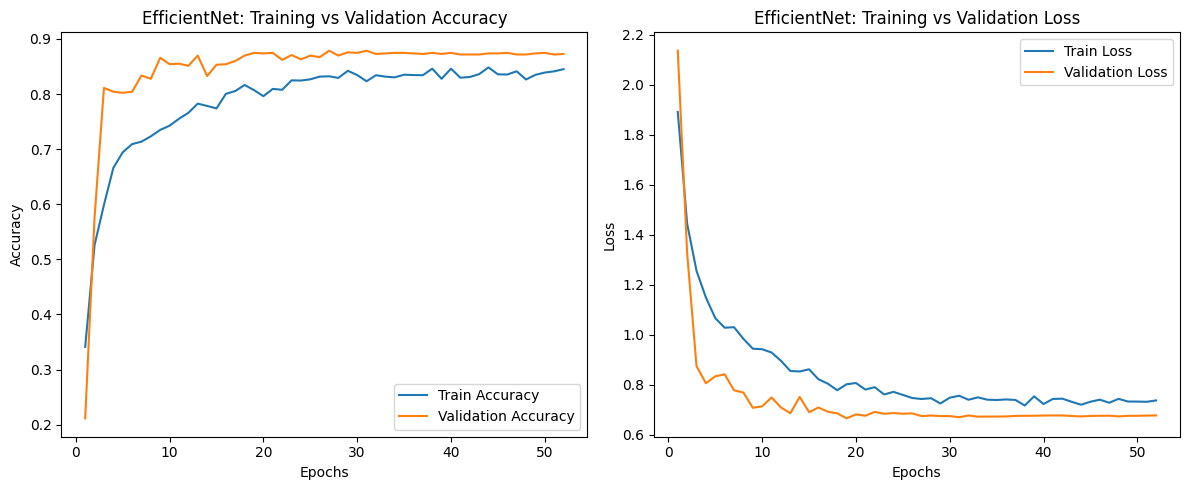

In [ ]:
import matplotlib.pyplot as plt

# Access the history dictionary from the History object
history_dict = history_efficientnet.history

epochs = range(1, len(history_dict["loss"]) + 1)
train_loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
train_acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label="Train Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("EfficientNet: Training vs Validation Accuracy")

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label="Train Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("EfficientNet: Training vs Validation Loss")

plt.tight_layout()
plt.show()

1/1 [==============================] - 5s 5s/step
[[137   0   0   0   0   0   4   7]
 [  0 122   7   7   3   1   8   2]
 [  2   1 132   0   2   0   5   8]
 [  0  12   0 121   5   4   2   5]
 [  0   7  10   4 127   2   0   0]
 [  0   8   0   7   2 133   0   0]
 [  5   6   8   0   0   0 123   8]
 [  3   5   6   5   0   0  10 121]]
Classification Report:
               precision    recall  f1-score   support

          A+       0.93      0.93      0.93       148
          A-       0.76      0.81      0.78       150
         AB+       0.81      0.88      0.84       150
         AB-       0.84      0.81      0.83       149
          B+       0.91      0.85      0.88       150
          B-       0.95      0.89      0.92       150
          O+       0.81      0.82      0.81       150
          O-       0.80      0.81      0.80       150

    accuracy                           0.85      1197
   macro avg       0.85      0.85      0.85      1197
weighted avg       0.85      0.85      0.85      

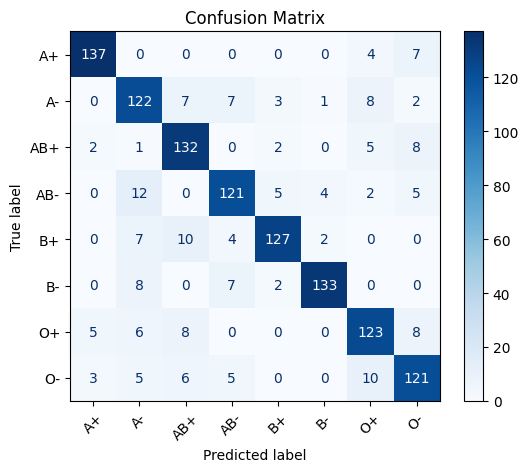

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def evaluate_model(model_path, df_test, classes):
    model = build_efficientnet()  # Rebuild the same architecture
    model.load_weights("efficientnet.h5")  # Load saved weights
    test_gen = HybridDataGenerator(df_test, classes, shuffle=False)
    y_true = []
    y_pred = []
    for (X_img, X_pat), y in test_gen:
        preds = model.predict([X_img, X_pat])
        y_true.extend(np.argmax(y, axis=1))
        y_pred.extend(np.argmax(preds, axis=1))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    # Classification Report
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=classes))

    # Visualization using ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()


classes=['A+', 'A-', 'AB+', 'AB-', 'B+', 'B-', 'O+', 'O-']  # Example call
df_test = pd.read_csv(r"C:\Users\mdtan\SCOPUS Project\imagewise_pattern_distribution_test.csv")
evaluate_model(r"C:\Users\mdtan\SCOPUS Project\efficientnet.h5", df_test, classes)


# DenseNet121

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Dropout, GlobalAveragePooling2D,
                                   Concatenate, BatchNormalization)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

def build_densenet(num_classes=8, img_size=(256, 256)):
    img_input = Input(shape=(256, 256, 3), name='img_input')
    pattern_input = Input(shape=(3,), name='pattern_input')  # One-hot: Arch, Whorl, Loop

    # EfficientNetB0 base
    base_model = DenseNet121(include_top=False, weights='imagenet', input_tensor=img_input)

    # Freeze initial layers (optional tuning strategy)
    for layer in base_model.layers[:280]:
        layer.trainable = False
    for layer in base_model.layers[280:]:
        layer.trainable = True

    # Image feature extraction
    x = GlobalAveragePooling2D()(base_model.output)

    # Combine image features with fingerprint pattern
    x = Concatenate()([x, pattern_input])
    x = Dense(512, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.4)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(0.3)(x)
    output = Dense(8, activation='softmax')(x)

    model = Model(inputs=[img_input, pattern_input], outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
        metrics=['accuracy']
    )
    return model



In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

model = build_densenet()




callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=25, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1),
    ModelCheckpoint('densenet_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]
history_densenet = model.fit(
    train_generator,
    epochs=150,
    validation_data=val_generator,
    callbacks=callbacks,class_weight=class_weights_dict
)

Epoch 1/150
97/97 [==============================] - ETA: 0s - loss: 1.4891 - accuracy: 0.5026   
Epoch 1: val_accuracy improved from -inf to 0.69148, saving model to densenet_model.h5
97/97 [==============================] - 105s 783ms/step - loss: 1.4891 - accuracy: 0.5026 - val_loss: 1.2201 - val_accuracy: 0.6915 - lr: 1.0000e-04
Epoch 2/150
97/97 [==============================] - ETA: 0s - loss: 0.9416 - accuracy: 0.7416  
Epoch 2: val_accuracy improved from 0.69148 to 0.82468, saving model to densenet_model.h5
97/97 [==============================] - 57s 586ms/step - loss: 0.9416 - accuracy: 0.7416 - val_loss: 0.8061 - val_accuracy: 0.8247 - lr: 1.0000e-04
Epoch 3/150
97/97 [==============================] - ETA: 0s - loss: 0.8089 - accuracy: 0.8022  
Epoch 3: val_accuracy improved from 0.82468 to 0.84525, saving model to densenet_model.h5
97/97 [==============================] - 56s 576ms/step - loss: 0.8089 - accuracy: 0.8022 - val_loss: 0.7274 - val_accuracy: 0.8452 - lr: 1.00

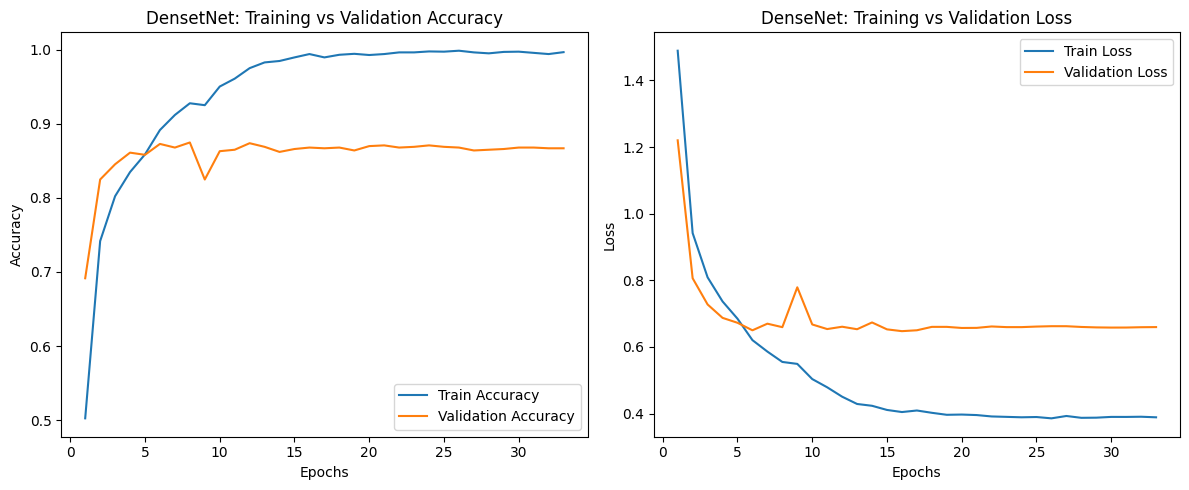

In [ ]:
import matplotlib.pyplot as plt

# Access the history dictionary from the History object
history_dict = history_densenet.history

epochs = range(1, len(history_dict["loss"]) + 1)
train_loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
train_acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label="Train Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("DensetNet: Training vs Validation Accuracy")

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label="Train Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("DenseNet: Training vs Validation Loss")

plt.tight_layout()
plt.show()

1/1 [==============================] - 7s 7s/step
Confusion Matrix:
 [[134   0   3   1   0   0   2   8]
 [  0 119   6   3   6   4  10   2]
 [  0   3 135   0   7   0   0   5]
 [  0  17   1 101  11   7   3   9]
 [  0   5  10   1 133   1   0   0]
 [  0   7   0   0   7 136   0   0]
 [  6   8  12   1   0   0 119   4]
 [  0   3   4   4   2   0   9 128]]
Classification Report:
               precision    recall  f1-score   support

          A+       0.96      0.91      0.93       148
          A-       0.73      0.79      0.76       150
         AB+       0.79      0.90      0.84       150
         AB-       0.91      0.68      0.78       149
          B+       0.80      0.89      0.84       150
          B-       0.92      0.91      0.91       150
          O+       0.83      0.79      0.81       150
          O-       0.82      0.85      0.84       150

    accuracy                           0.84      1197
   macro avg       0.85      0.84      0.84      1197
weighted avg       0.85      0

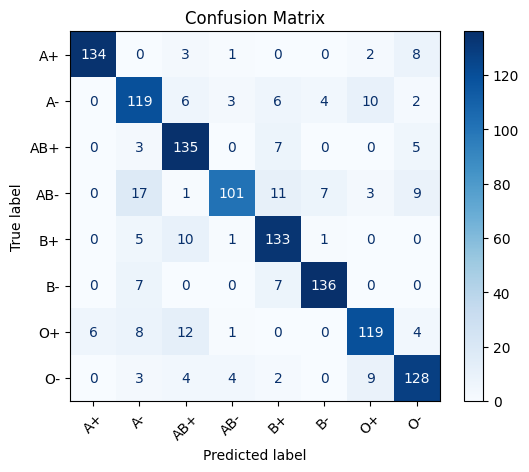

array([[134,   0,   3,   1,   0,   0,   2,   8],
       [  0, 119,   6,   3,   6,   4,  10,   2],
       [  0,   3, 135,   0,   7,   0,   0,   5],
       [  0,  17,   1, 101,  11,   7,   3,   9],
       [  0,   5,  10,   1, 133,   1,   0,   0],
       [  0,   7,   0,   0,   7, 136,   0,   0],
       [  6,   8,  12,   1,   0,   0, 119,   4],
       [  0,   3,   4,   4,   2,   0,   9, 128]], dtype=int64)

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def evaluate_model(model_path, df_test, classes):
    model = load_model(model_path)
    test_gen = HybridDataGenerator(df_test, classes, shuffle=False)
    y_true = []
    y_pred = []
    for (X_img, X_pat), y in test_gen:
        preds = model.predict([X_img, X_pat])
        y_true.extend(np.argmax(y, axis=1))
        y_pred.extend(np.argmax(preds, axis=1))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)

    # Classification Report
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=classes))

    # Visualization using ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

    return cm

classes=['A+', 'A-', 'AB+', 'AB-', 'B+', 'B-', 'O+', 'O-']  # Example call
df_test = pd.read_csv(r"C:\Users\mdtan\SCOPUS Project\imagewise_pattern_distribution_test.csv")
evaluate_model(r"C:\Users\mdtan\SCOPUS Project\densenet_model.h5", df_test, classes)


# Ensemble Model

Confusion Matrix:
 [[135   0   1   0   0   0   3   9]
 [  0 126   6   2   4   1   3   2]
 [  0   2 139   0   3   0   1   5]
 [  0  10   0 103   9   4   2   1]
 [  0   6   4   1 139   0   0   0]
 [  0   3   0   1   3 143   0   0]
 [  1   4   9   1   0   0 126   5]
 [  0   3   5   3   0   0   8 131]]
Ensemble Classification Report:
               precision    recall  f1-score   support

          A+       0.99      0.91      0.95       148
          A-       0.82      0.88      0.85       144
         AB+       0.85      0.93      0.89       150
         AB-       0.93      0.80      0.86       129
          B+       0.88      0.93      0.90       150
          B-       0.97      0.95      0.96       150
          O+       0.88      0.86      0.87       146
          O-       0.86      0.87      0.86       150

    accuracy                           0.89      1167
   macro avg       0.90      0.89      0.89      1167
weighted avg       0.90      0.89      0.89      1167



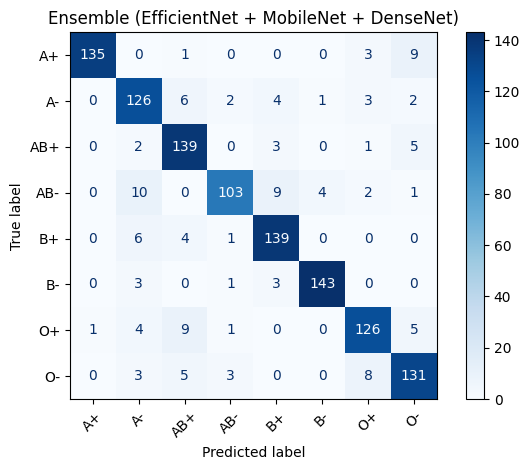

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def ensemble_evaluate(
    efficientnet_path,
    mobilenet_path,
    densenet_path,
    df_test,
    classes,
    weights=[0.33, 0.33, 0.34]
):
    # Load EfficientNet
    efficientnet = build_efficientnet()
    efficientnet.load_weights(efficientnet_path)

    # Load MobileNet and DenseNet models
    mobilenet = load_model(mobilenet_path)
    densenet = load_model(densenet_path)

    test_gen = HybridDataGenerator(df_test, classes, shuffle=False)
    y_true = []
    preds_eff, preds_mob, preds_den = [], [], []

    for (X_img, X_pat), y in test_gen:
        y_true.extend(np.argmax(y, axis=1))

        pred_eff = efficientnet.predict([X_img, X_pat], verbose=0)
        pred_mob = mobilenet.predict([X_img, X_pat], verbose=0)
        pred_den = densenet.predict([X_img, X_pat], verbose=0)

        preds_eff.append(pred_eff)
        preds_mob.append(pred_mob)
        preds_den.append(pred_den)

    # Stack predictions
    preds_eff = np.vstack(preds_eff)
    preds_mob = np.vstack(preds_mob)
    preds_den = np.vstack(preds_den)

    # Weighted ensemble
    y_pred_ensemble = (
        weights[0] * preds_eff +
        weights[1] * preds_mob +
        weights[2] * preds_den
    )
    y_pred = np.argmax(y_pred_ensemble, axis=1)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)

    # Classification Report
    print("Ensemble Classification Report:\n",
          classification_report(y_true, y_pred, target_names=classes))

    # Plot
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title("Ensemble (EfficientNet + MobileNet + DenseNet)")
    plt.tight_layout()
    plt.show()

# Usage
classes = ['A+', 'A-', 'AB+', 'AB-', 'B+', 'B-', 'O+', 'O-']
df_test = pd.read_csv(r"C:\Users\mdtan\SCOPUS Project\imagewise_pattern_distribution_test.csv")

ensemble_evaluate(
    efficientnet_path="efficientnet.h5",
    mobilenet_path="mobilenet_model_pattern.h5",
    densenet_path="densenet_model.h5",
    df_test=df_test,
    classes=classes,
    weights=[0.33, 0.33, 0.33]  # Fine-tune based on individual accuracy
)


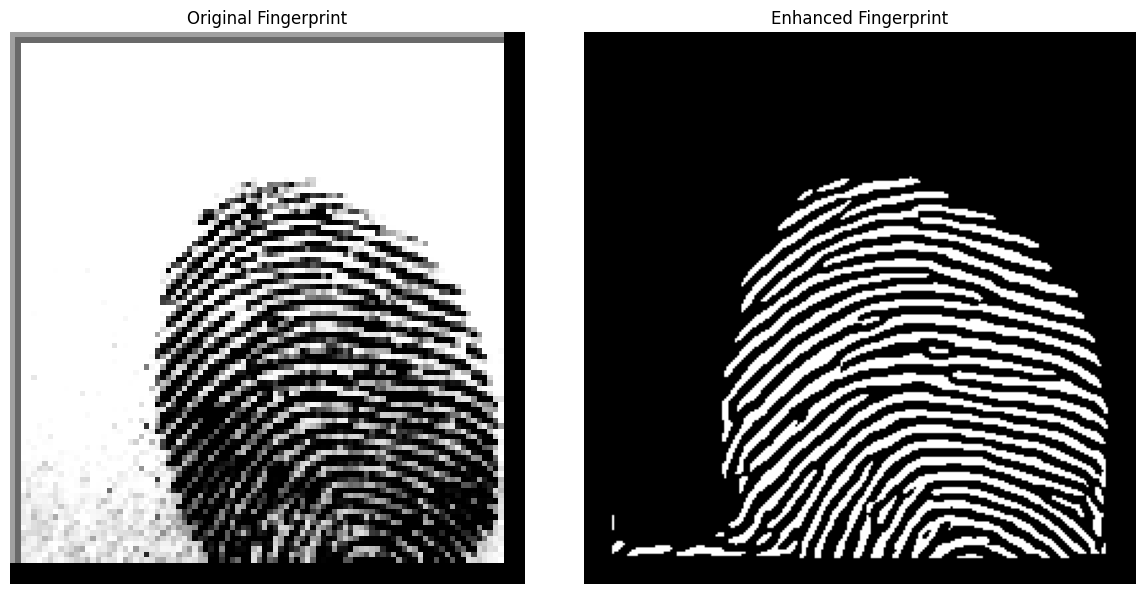

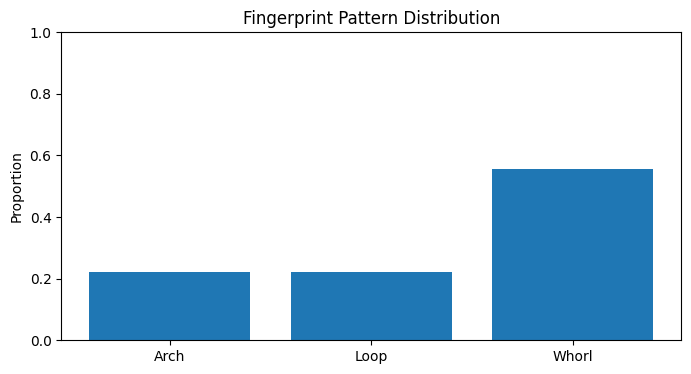


🧬 Predicted Blood Group: AB+ (Confidence: 98.22%)

📊 Pattern Distribution:
Arch: 22.2%
Loop: 22.2%
Whorl: 55.6%

🔍 Confidence scores for all classes:
A+  : 0.37%
A-  : 0.12%
AB+ : 98.22%
AB- : 0.14%
B+  : 0.31%
B-  : 0.19%
O+  : 0.14%
O-  : 0.52%


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
import fingerprint_enhancer
from tqdm import tqdm

# Configuration
IMG_EXTS = (".bmp", ".BMP", ".jpg", ".jpeg", ".png")
MODEL_PATHS = {
    'efficientnet': "efficientnet.h5",
    'mobilenet': "mobilenet_model_pattern.h5",
    'densenet': "densenet_model.h5"
}
class_names = ['A+', 'A-', 'AB+', 'AB-', 'B+', 'B-', 'O+', 'O-']
PATCH_SIZE = 64  # Size for fingerprint pattern analysis

# Image Enhancement Parameters
denoise_h = 10
denoise_hColor = 10
templateWindowSize = 7
searchWindowSize = 21
alpha = 1.2   # contrast
beta = 20     # brightness
sharpen_kernel = np.array([[-1, -1, -1],
                           [-1,  9, -1],
                           [-1, -1, -1]])
TARGET_SIZE = (256, 256)

# Pattern Analysis Functions
def compute_orientation(block):
    """Calculate dominant orientation using gradient information"""
    gx = cv2.Sobel(block, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(block, cv2.CV_64F, 0, 1, ksize=3)
    return 0.5 * np.arctan2(2 * np.sum(gx * gy), np.sum(gx**2 - gy**2))

def classify_pattern_distribution(angle_deg):
    """Classify pattern based on orientation angle"""
    angle_deg = angle_deg % 180
    if 75 < angle_deg < 105: return 'Arch'
    if 30 < angle_deg <= 75: return 'Loop'
    if angle_deg <= 30 or angle_deg >= 150: return 'Whorl'
    return 'Other'

def get_pattern_distribution(img):
    """Calculate pattern distribution for a single image"""
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    img = cv2.resize(img, (256, 256))
    img = cv2.GaussianBlur(img, (3, 3), 0)
    counts = {'Arch': 0, 'Loop': 0, 'Whorl': 0, 'Other': 0}

    for y in range(0, 256 - PATCH_SIZE, PATCH_SIZE):
        for x in range(0, 256 - PATCH_SIZE, PATCH_SIZE):
            block = img[y:y+PATCH_SIZE, x:x+PATCH_SIZE]
            angle = compute_orientation(block)
            pattern = classify_pattern_distribution(np.degrees(angle))
            counts[pattern] += 1

    total = sum(counts.values())
    return [counts['Arch']/total, counts['Loop']/total, counts['Whorl']/total]

def enhance_image(img):
    """Enhance fingerprint image through multiple steps"""
    # 1) Denoise color
    denoised = cv2.fastNlMeansDenoisingColored(img, None, denoise_h, denoise_hColor,
                                              templateWindowSize, searchWindowSize)
    # 2) Sharpen
    sharpened = cv2.filter2D(denoised, -1, sharpen_kernel)

    # 3) Brightness & Contrast
    adjusted = cv2.convertScaleAbs(sharpened, alpha=alpha, beta=beta)

    # 4) Resize
    resized = cv2.resize(adjusted, TARGET_SIZE, interpolation=cv2.INTER_AREA)

    # 5) Convert to grayscale for fingerprint enhancement
    gray_img = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    gray_img = cv2.equalizeHist(gray_img)

    # 6) Fingerprint enhancement
    enhanced_fp = fingerprint_enhancer.enhance_fingerprint(gray_img)
    enhanced_uint8 = (enhanced_fp * 255).astype(np.uint8)

    return enhanced_uint8

def load_ensemble_models():
    """Load all models for ensemble prediction"""
    models = {}
    for name, path in MODEL_PATHS.items():
        if name == 'efficientnet':
            # Assuming EfficientNet is a custom model with similar interface
            model = build_efficientnet()
            model.load_weights('efficientnet.h5')
        else:
            model = load_model(path)
        models[name] = model
    return models

def ensemble_predict(models, image_input, pattern_input, weights=[0.33, 0.33, 0.34]):
    """Make prediction using ensemble of models"""
    preds = []
    for name, model in models.items():
        pred = model.predict([image_input, pattern_input], verbose=0)
        preds.append(pred)

    # Weighted ensemble prediction
    ensemble_pred = (
        weights[0] * preds[0] +
        weights[1] * preds[1] +
        weights[2] * preds[2]
    )
    return ensemble_pred

def analyze_fingerprint(image_path):
    """Complete analysis pipeline for a single fingerprint image"""
    # 1. Load and validate image
    original_img = cv2.imread(image_path)
    if original_img is None:
        raise FileNotFoundError(f"Cannot load input image: {image_path}")

    # 2. Enhance image
    enhanced_img = enhance_image(original_img)

    # 3. Calculate pattern distribution
    pattern_dist = get_pattern_distribution(enhanced_img)
    pattern_input = np.array([pattern_dist])

    # 4. Prepare image input for model
    normalized = enhanced_img.astype('float32') / 255.0
    rgb_input = np.stack((normalized,) * 3, axis=-1)
    image_input = np.expand_dims(rgb_input, axis=0)

    # 5. Load models and make prediction
    models = load_ensemble_models()
    ensemble_pred = ensemble_predict(models, image_input, pattern_input)

    # 6. Process results
    confidence_scores = ensemble_pred[0]
    predicted_index = np.argmax(confidence_scores)
    predicted_class = class_names[predicted_index]

    # 7. Display results
    plt.figure(figsize=(12, 6))

    # Original and enhanced images
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    plt.title("Original Fingerprint")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(enhanced_img, cmap='gray')
    plt.title("Enhanced Fingerprint")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Pattern distribution
    patterns = ['Arch', 'Loop', 'Whorl']
    plt.figure(figsize=(8, 4))
    plt.bar(patterns, pattern_dist)
    plt.title("Fingerprint Pattern Distribution")
    plt.ylabel("Proportion")
    plt.ylim(0, 1)
    plt.show()

    # Prediction results
    print(f"\n🧬 Predicted Blood Group: {predicted_class} (Confidence: {confidence_scores[predicted_index]*100:.2f}%)")
    print("\n📊 Pattern Distribution:")
    for pat, val in zip(patterns, pattern_dist):
        print(f"{pat}: {val*100:.1f}%")

    print("\n🔍 Confidence scores for all classes:")
    for idx, score in enumerate(confidence_scores):
        print(f"{class_names[idx]:<4}: {score * 100:.2f}%")

    return {
        'enhanced_image': enhanced_img,
        'pattern_distribution': dict(zip(patterns, pattern_dist)),
        'predicted_class': predicted_class,
        'confidence': confidence_scores[predicted_index],
        'all_scores': confidence_scores
    }

# Main execution
if __name__ == "__main__":
    # Example usage
    img_path = r"C:\Users\mdtan\OneDrive\Desktop\New folder (4)\AB+\cluster_4_51.BMP"
    results = analyze_fingerprint(img_path)

#  Prediction